In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [8]:
data_dir = './flower_data/'

In [9]:
data_transforms = {  # 数据预处理
    'train': transforms.Compose([transforms.RandomRotation(45),  # 随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),  # 从中心开始裁剪成224 * 224
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),  # 随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),  # 参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),  # 概率转换成灰度图，3通道灰度图就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet的均值，标准差
    ]),
    'valid': transforms.Compose([transforms.Resize(256),  # 验证集
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
batch_size = 8

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [11]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456,

In [12]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x23319648550>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x233196405e0>}

In [13]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [14]:
class_names

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [15]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [16]:
def im_convert(tensor):
    """ 展示数据 """

    image = tensor.to("cpu").clone().detach()  # 拷贝一份
    image = image.numpy().squeeze()  # 展开操作，去除第一维度
    image = image.transpose(1, 2, 0)  # 各个维度之间交换值
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # 逆标准化
    image = image.clip(0, 1)  # 去除0~1以外的值

    return image

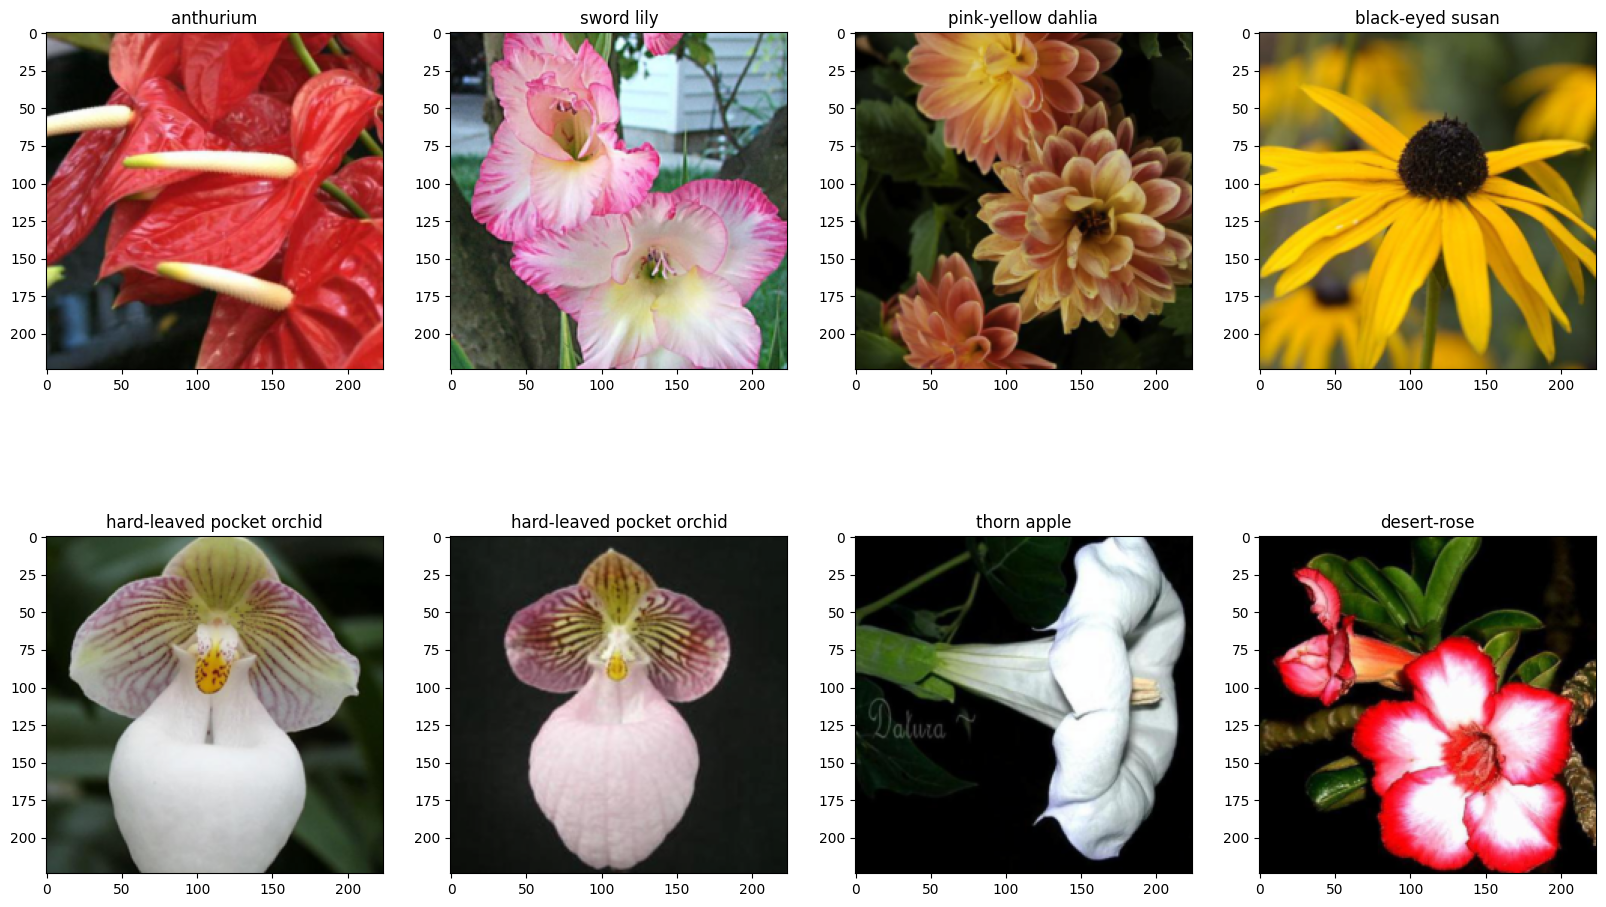

In [17]:
fig = plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.__next__()

for idx in range (columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1)  # 几行几列第几个
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])  # 设置标题
    plt.imshow(im_convert(inputs[idx]))  # 添加图片
plt.show()  # 展示图片

In [18]:
dataiter_2 = iter(dataloaders['train'])
item = dataiter_2.__next__()
item

[tensor([[[[ 0.4679,  0.5536,  0.5536,  ..., -1.8268, -1.8610, -1.8439],
           [ 0.6734,  0.5536,  0.5536,  ..., -1.8610, -1.8610, -1.8610],
           [ 0.8276,  0.5707,  0.5193,  ..., -1.8782, -1.8610, -1.8268],
           ...,
           [ 1.0159,  0.9646,  0.8789,  ..., -0.0972,  0.0398,  0.0912],
           [ 0.9474,  0.9474,  0.8789,  ..., -0.1143, -0.0972,  0.0741],
           [ 0.9132,  0.8789,  0.8104,  ..., -0.2856, -0.0972, -0.0972]],
 
          [[-0.0399, -0.0049, -0.0049,  ..., -1.5105, -1.5455, -1.5630],
           [ 0.1527, -0.0049, -0.0049,  ..., -1.5455, -1.5455, -1.5455],
           [ 0.2752,  0.0301, -0.0399,  ..., -1.5455, -1.5455, -1.5455],
           ...,
           [ 0.6604,  0.5903,  0.5028,  ..., -0.8102, -0.6702, -0.6527],
           [ 0.5903,  0.5903,  0.5028,  ..., -0.8452, -0.8277, -0.6702],
           [ 0.5378,  0.5028,  0.4503,  ..., -1.0203, -0.8277, -0.8627]],
 
          [[ 1.1062,  1.1934,  1.2282,  ..., -1.2990, -1.3339, -1.3513],
           [ 

In [19]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda


In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [22]:
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True

In [23]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [24]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

In [21]:

model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

Epoch 0/9
----------
Time elapsed 2m 2s
train Loss: 6.8281 Acc: 0.3834
Time elapsed 2m 14s
valid Loss: 6.4230 Acc: 0.4059
Optimizer learning rate : 0.0100000

Epoch 1/9
----------
Time elapsed 4m 12s
train Loss: 4.9375 Acc: 0.5462
Time elapsed 4m 23s
valid Loss: 6.7433 Acc: 0.4963
Optimizer learning rate : 0.0100000

Epoch 2/9
----------
Time elapsed 6m 20s
train Loss: 4.5516 Acc: 0.6136
Time elapsed 6m 32s
valid Loss: 7.3012 Acc: 0.5513
Optimizer learning rate : 0.0100000

Epoch 3/9
----------
Time elapsed 8m 29s
train Loss: 4.2756 Acc: 0.6621
Time elapsed 8m 40s
valid Loss: 6.9424 Acc: 0.5660
Optimizer learning rate : 0.0100000

Epoch 4/9
----------
Time elapsed 10m 37s
train Loss: 4.1890 Acc: 0.6835
Time elapsed 10m 49s
valid Loss: 10.8821 Acc: 0.5012
Optimizer learning rate : 0.0100000

Epoch 5/9
----------
Time elapsed 12m 45s
train Loss: 4.6141 Acc: 0.6838
Time elapsed 12m 57s
valid Loss: 10.1648 Acc: 0.5391
Optimizer learning rate : 0.0100000

Epoch 6/9
----------
Time elapsed 1

In [25]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [38]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))  # 制作缩略图
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,  # 图像裁剪
                      top_margin))
    # 相同的预处理方法
    # print(img)
    img = np.array(img)/255  # 归一化
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std  # 标准化

    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))

    return img

In [42]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()

    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))

    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    print(img)

    ax.imshow(image)
    ax.set_title(title)

    return ax

[[[-0.73079887 -0.62805035 -0.52530182 ... -0.02868396  0.0226903
    0.05693981]
  [-0.90204641 -0.79929789 -0.71367412 ... -0.11430773 -0.08005822
   -0.02868396]
  [-1.00479493 -0.91917116 -0.85067215 ... -0.16568199 -0.16568199
   -0.13143249]
  ...
  [-0.47392756 -0.33692953 -0.21705625 ...  0.05693981  0.09118931
    0.07406456]
  [-0.47392756 -0.37117904 -0.28555527 ...  0.00556554  0.03981505
    0.0226903 ]
  [-0.54242658 -0.47392756 -0.4225533  ... -0.02868396  0.00556554
    0.0226903 ]]

 [[-0.60014006 -0.49509804 -0.39005602 ...  0.20518207  0.25770308
    0.29271709]
  [-0.75770308 -0.65266106 -0.56512605 ...  0.11764706  0.17016807
    0.20518207]
  [-0.8627451  -0.77521008 -0.70518207 ...  0.03011204  0.03011204
    0.06512605]
  ...
  [-0.35504202 -0.19747899 -0.09243697 ...  0.15266106  0.18767507
    0.17016807]
  [-0.42507003 -0.30252101 -0.21498599 ...  0.15266106  0.15266106
    0.11764706]
  [-0.47759104 -0.40756303 -0.35504202 ...  0.11764706  0.11764706
    0.1

<AxesSubplot: >

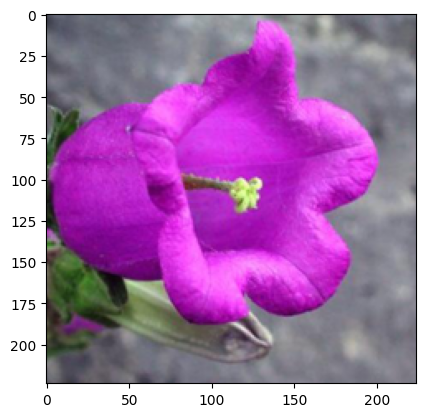

In [43]:
image_path = 'image_06621.jpg'
img = process_image(image_path)
imshow(img)

In [30]:
img.shape

(3, 224, 224)

In [49]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.__next__()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [45]:
output.shape

torch.Size([8, 102])

In [50]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([ 84,   2,  49,  50,  14, 101,  13,  61], dtype=int64)

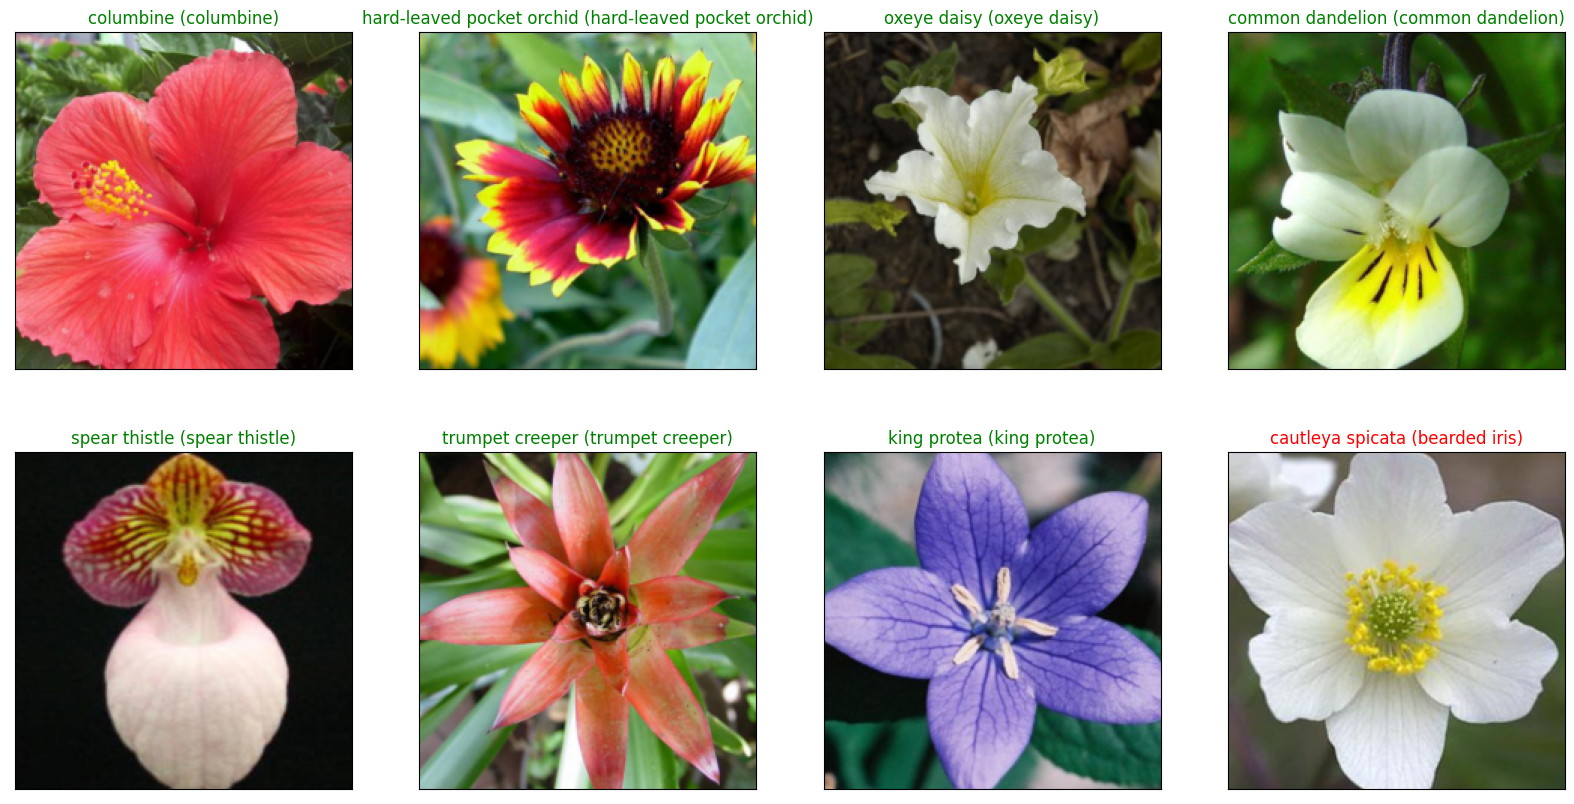

In [58]:
fig = plt.figure(figsize=(20, 10))
columns = 4
rows = 2

for idx in range (columns * rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])] == cat_to_name[str(labels[idx].item())] else "red"))
# plt.show()